# Transfer Learning Part 2: Fine Tuning

In the previous notebook, we covered transfer learning feature extranction but now, we are going to learn about new kind of transfer learning: fine-tuning.


This time we are going to see how we can use the pretrained models within `tf.keras.applications` and apply them to on our problem. (food recognization)

In [9]:
# Import necessary libraries
import os
import datetime
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

print(tf.__version__)

2.12.0


## Get some data


In [2]:
# Get %10 of training data of 10 classes of Food101
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-07 08:18:36--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  20.9MB/s    in 8.5s    

2023-07-07 08:18:45 (18.9 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
# Check out how many images and directories we have
for dir in os.walk('10_food_classes_10_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_10_percent'
There are 10 directories and 0 images in '10_food_classes_10_percent/train'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/hamburger'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'
There are 0 directories and 75 images in '10_food_classes_10_percent/train/rame

In [4]:
# Creating training and test directories path
train_dir = '/content/10_food_classes_10_percent/train/'
test_dir = '/content/10_food_classes_10_percent/test/'

In [5]:
# Set global image size and batch size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Load train and test images into batches
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            label_mode='categorical',
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE)

test_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [6]:
# Check out the train batch datasets
train_data_10_percent

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

In previous notebook, I generally prefered to use Sequential model but in this notebook, I will use functional API models. The sequential model is straight-forward, it runs our layer is sequential order. But the functional API gives us more flexibility with our models.

Sequential API Models:

* Sequential models are a linear stack of layers, where each layer is connected to the next in a sequential manner.
* They are suitable for simple, sequential modeling tasks with a single input and a single output.
* They are easy to use and have a straightforward structure, making them ideal for beginners or simple architectures.
* Sequential models do not support multiple inputs or outputs without workarounds.
* They are less flexible when it comes to complex model architectures or shared layers.

Functional API Models:

* Functional API models allow for more complex and flexible model architectures.
* They enable the creation of models with multiple inputs and outputs, making them suitable for tasks that require multiple data streams or multiple predictions.
* Functional models are not limited to a linear stack of layers and can contain branching or merging layers, allowing for more intricate architectures.
* They support shared layers, which means the same layer can be called multiple times with different inputs, allowing for weight sharing and reuse.
* Functional models can handle complex computations, including conditional branches and loops, making them more suitable for advanced use cases.
* They provide more control over the model structure and allow for the creation of models with shared layers, skip connections, or complex architectures.


Functional API: https://www.tensorflow.org/guide/keras/functional_api



Here is what we will be experimenting with:

* Model 0:
    * Data: Random **%10** training data only (Food101)
    * Preprocessing: None
    * Model: EfficientNetB0 **feature extractor** model with no top (all layers frozen)

* Model 1:
    * Data: Random **%1** training data only (Food101)
    * Preprocessing: Data augmentation
    * Model: EfficientNetB0 **feature extractor** model with no top (all layers frozen)

* Model 2:
    * Data: Random **%10** training data only (Food101)
    * Preprocessing: Data augmentation
    * Model: EfficientNetB0 **feature extractor** model with no top (all layers frozen)

* Model 3:
    * Data: Random **%10** training data only (Food101)
    * Preprocessing: Data augmentation
    * Model: EfficientNetB0 **fine tuning** model (top 10 layers unfrozen)

* Model 4:
    * Data: Random **%100** training data only (Food101)
    * Preprocessing: Data augmentation
    * Model: EfficientNetB0 **fine tuning** model (top 10 layers unfrozen)

## Base model - Model 0
Data: Random **%10** training data only (Food101)
<br>Preprocessing: None
<br>Model: EfficientNetB0 **feature extractor** model with no top (all layers frozen)

In [7]:
# Create a TensorBoard callbakc (functionized because we need to create a new one for each model)
def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    print(f'Saving TensorBoard log files to: {log_dir}')
    return tensorboard_callback

In [10]:
# 1. Create a base with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # this model output layer is 1000 but in our case we have 10 outputs
                                                                     # so include_top should be false

# 2. Freeze the base model (so the underlying pre-trained patters aren't updated during training)
base_model.trainable = False

# 3. Create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name='input_layer')

# 4. If using ResNet50V2 you will need to normalize inputs (EfficientNet has already rescaling built-in)
# x = tf.keras.layers.experimantal.preprocessing.Rescaling(1./255)(inputs)

# 5. Pass the inputs to the base model
x = base_model(inputs)
print(f'Shape after passing inputs  through base model: {x.shape}')

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computation)
x = tf.keras.layers.GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
print(f'Shape after GlobalAveragePooling2D: {x.shape}')

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(x)

# 8. Compine the inputs and outputs into a model
model_0 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_0.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

# 10. Fit the model and save its history
model_0_history = model_0.fit(train_data_10_percent,
                              epochs=5,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data_10_percent,
                              validation_steps=len(test_data_10_percent),
                              callbacks=[create_tensorboard_callback(dir_name='transfer_learning',
                                                                     experiment_name='Model_0_10_percent_feature_extraction')])

Shape after passing inputs  through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/Model_0_10_percent_feature_extraction/20230707-092218
Epoch 1/5
24/24 [==============================] - 25s 445ms/step - loss: 1.9171 - accuracy: 0.4093 - val_loss: 1.3263 - val_accuracy: 0.7204
Epoch 2/5
24/24 [==============================] - 8s 313ms/step - loss: 1.1138 - accuracy: 0.7747 - val_loss: 0.8752 - val_accuracy: 0.8120
Epoch 3/5
24/24 [==============================] - 7s 295ms/step - loss: 0.7976 - accuracy: 0.8333 - val_loss: 0.7003 - val_accuracy: 0.8412
Epoch 4/5
24/24 [==============================] - 8s 324ms/step - loss: 0.6333 - accuracy: 0.8680 - val_loss: 0.6094 - val_accuracy: 0.8516
Epoch 5/5
24/24 [==============================] - 12s 509ms/step - loss: 0.5538 - accuracy: 0.8787 - val_loss: 0.5546 - val_accuracy: 0.8620


In [13]:
# Check the layers in our base model
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name)

0 input_2
1 rescaling_2
2 normalization_1
3 rescaling_3
4 stem_conv_pad
5 stem_conv
6 stem_bn
7 stem_activation
8 block1a_dwconv
9 block1a_bn
10 block1a_activation
11 block1a_se_squeeze
12 block1a_se_reshape
13 block1a_se_reduce
14 block1a_se_expand
15 block1a_se_excite
16 block1a_project_conv
17 block1a_project_bn
18 block2a_expand_conv
19 block2a_expand_bn
20 block2a_expand_activation
21 block2a_dwconv_pad
22 block2a_dwconv
23 block2a_bn
24 block2a_activation
25 block2a_se_squeeze
26 block2a_se_reshape
27 block2a_se_reduce
28 block2a_se_expand
29 block2a_se_excite
30 block2a_project_conv
31 block2a_project_bn
32 block2b_expand_conv
33 block2b_expand_bn
34 block2b_expand_activation
35 block2b_dwconv
36 block2b_bn
37 block2b_activation
38 block2b_se_squeeze
39 block2b_se_reshape
40 block2b_se_reduce
41 block2b_se_expand
42 block2b_se_excite
43 block2b_project_conv
44 block2b_project_bn
45 block2b_drop
46 block2b_add
47 block3a_expand_conv
48 block3a_expand_bn
49 block3a_expand_activati

In [15]:
# How about the summary of the base model?
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_2 (Rescaling)        (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_1 (Normalization  (None, None, None,   7          ['rescaling_2[0][0]']            
 )                              3)                                                   

In [16]:
# How about the summary of the model_0?
model_0.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


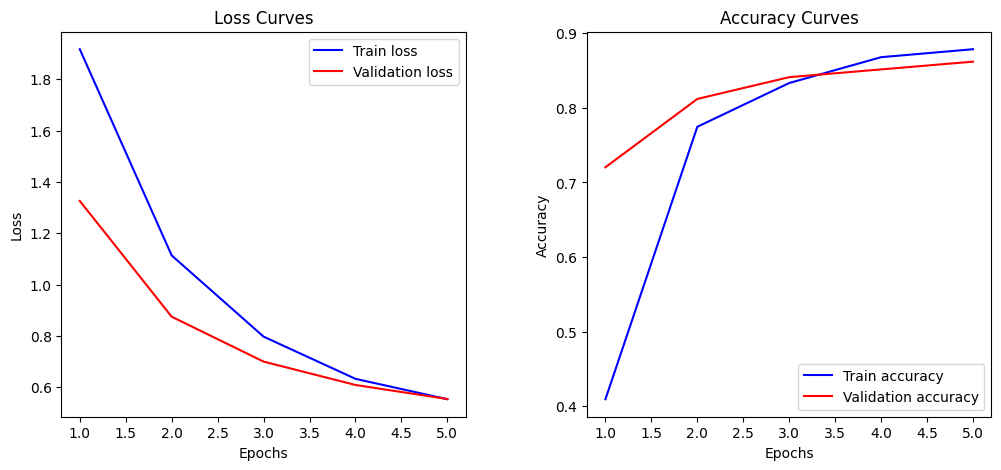

In [19]:
# Check out the plot loss curves
def plot_loss_curves(history):

    '''
    Plot the loss and accuracy curves for training and validation parts.

    Args:
        history: TensorFlow history object.
    Returns:
        Loss and accuracy curves for training and validation
    '''

    # Convert history to dataframe
    dataframe = pd.DataFrame(history.history)
    dataframe = dataframe.set_index(pd.Index(range(1, len(dataframe) + 1)))

    # Set the plot size
    plt.figure(figsize=(12, 5))

    # Plot train and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(dataframe['loss'], 'b', label='Train loss')
    plt.plot(dataframe['val_loss'], 'r', label='Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()

    # Plot train and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(dataframe['accuracy'], 'b', label='Train accuracy')
    plt.plot(dataframe['val_accuracy'], 'r', label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Curves')
    plt.legend()

    # Adjust spaces and plot
    plt.subplots_adjust(wspace=0.3)
    plt.show()


plot_loss_curves(model_0_history)

## Getting a feature vector from a trained model


Let's demonstrate the Glabal Average Pooling 2D layer.

We have a tensor after our model goes through `base_model` of shape (None, 7, 7, 1280).

But then when it pass through GloabalAveragePooling2D, it turns into (None, 1280)

Let's use a similiar shaped tensor of (1, 4, 4, 3) and then pass it to GlobalAveragePooling2D.

In [32]:
# Define the input shape
input_shape = (1, 4, 4, 3)

# Create a random tensor
input_tensor = tf.random.normal(input_shape)
print(f'Random input tensor: \n {input_tensor}\n')

# Pass the tensor through the global average pooling 2D layer
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f'2D Global Average Pooled tensor:\n{global_average_pooled_tensor}\n')
global_average_pooled_tensor

# Check the shape of tensors
print(f'Shape of the input tensor: {input_tensor.shape}')
print(f'Shape of the 2D Global Average Pooled tensor: {global_average_pooled_tensor.shape}')

Random input tensor: 
 [[[[-0.7650152   1.2578322   0.66651875]
   [ 0.56901693 -0.7061107   0.9091051 ]
   [-0.45729834  0.35121456  1.1505542 ]
   [-1.3862677   0.9606734  -2.236597  ]]

  [[-1.3169045  -0.49145722 -0.8855881 ]
   [ 0.24625611  2.0945303   0.29875746]
   [ 1.0482002  -0.25965872  0.34538546]
   [ 0.11430746  0.30418813  1.1580254 ]]

  [[ 0.93979734 -0.40647566 -0.24763994]
   [ 0.9000725  -0.5480312   0.3461225 ]
   [-1.1878935   0.80285144 -0.20316957]
   [-2.0171723   0.6561421   2.1681309 ]]

  [[ 0.39176    -0.3909106   1.2689863 ]
   [-0.7430524   0.7083148   1.1482161 ]
   [ 1.5312681   1.3160715   0.8586005 ]
   [-1.1910853   0.73490983 -0.29960647]]]]

2D Global Average Pooled tensor:
[[-0.20775065  0.39900523  0.40286264]]

Shape of the input tensor: (1, 4, 4, 3)
Shape of the 2D Global Average Pooled tensor: (1, 3)


In [33]:
# Let's replicate the GlobalAveragePooling2D
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.20775065,  0.39900523,  0.40286264]], dtype=float32)>

## Model 1

The model will remain the same in this part (EfficientNetB0). However, we will use only 1% of data for training instead of 10% and compare the results with model_0 by using data augmentation techniques to increase the diversity of data.

* Data: Random %1 training data only (Food101)
* Preprocessing: Data augmentation
* Model: EfficientNetB0 feature extractor model with no top (all layers frozen)



In [34]:
# Download and unzip the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

zip_ref = zipfile.ZipFile('10_food_classes_1_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-07-07 11:26:12--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 142.250.4.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  23.5MB/s    in 6.5s    

2023-07-07 11:26:19 (19.5 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [39]:
# Create the train and test dir
train_dir = '10_food_classes_1_percent/train/'
test_dir = '10_food_classes_1_percent/test/'

In [37]:
# How many images and directories we have?
for dir in os.walk('10_food_classes_1_percent'):
    print(f"There are {len(dir[1])} directories and {len(dir[2])} images in '{dir[0]}'")

There are 2 directories and 0 images in '10_food_classes_1_percent'
There are 10 directories and 0 images in '10_food_classes_1_percent/train'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'
There are 10 direct

**Note that we only have 7 images for each classes for training.**

In [40]:
# Set up data loaders
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                           label_mode='categorical',
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                          label_mode='categorical',
                                                                          image_size=IMG_SIZE,
                                                                          batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


### Adding data augmentation into our model
To add data augmentation right into our models, we can use the layers inside:
* `tf.keras.layers.experimental.preprocessing`

Link: https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing

In [44]:
from tensorflow.keras.layers.experimental import preprocessing

# Create data augmentation stage with horizontal flipping, rotations, zooms, etc.
data_augmentation = tf.keras.Sequential([
    preprocessing.RandomFlip('horizontal'),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    # preprocessing.Rescale(1./255) # This is for ResNet50V2 but for EfficientNet we dont need that
], name='data_augmentation')